In [1]:
import glob
import sys

import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, XGBRFClassifier

sys.path.append("../../../")

from helpers.experiment import experiment
from helpers.split import tag_label_feature_split

/Users/rerobbins/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index




Commencing Experiment: XGBClassifier_dataset_00_all

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       1.0000     280

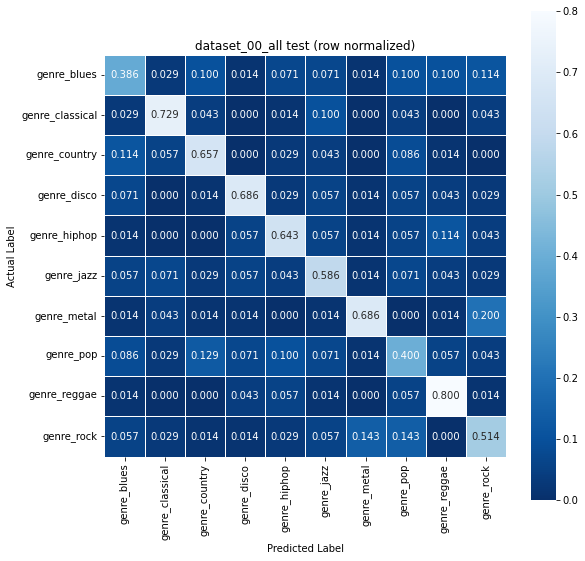



Commencing Experiment: XGBClassifier_dataset_01_mean

Training accuracy: train_accuracy = 0.999643

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.9964    0.9982      280  0.9980
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     0.9964  1.0000    0.9982      280  0.9980
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       0.9996     28

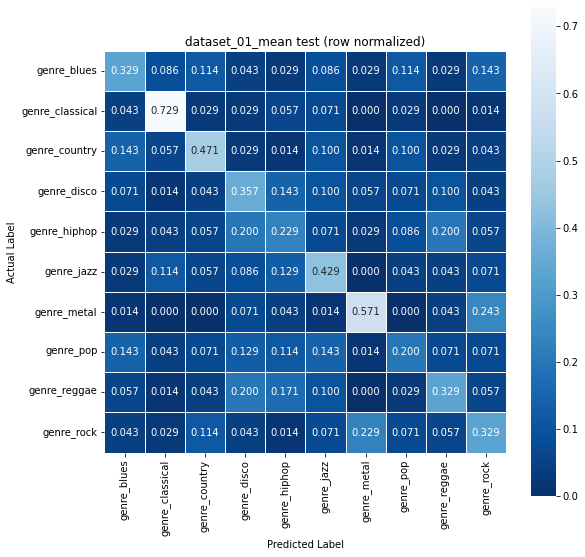



Commencing Experiment: XGBClassifier_dataset_02_mean_cov

Training accuracy: train_accuracy = 0.999643

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  0.9964    0.9982      280  0.9980
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     0.9964  1.0000    0.9982      280  0.9980
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       0.9996   

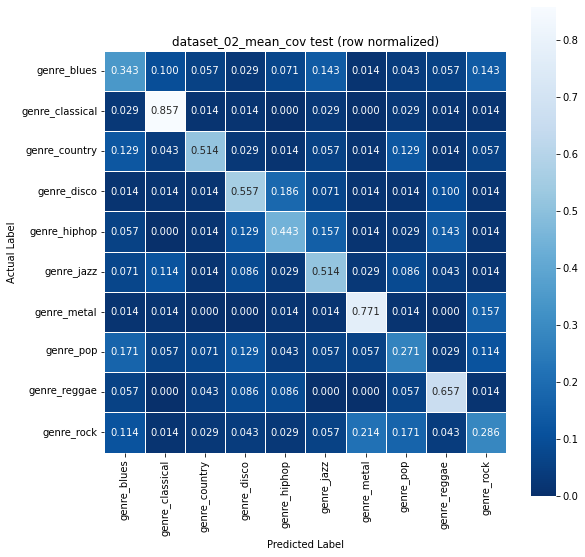



Commencing Experiment: XGBClassifier_dataset_03_mean_icov

Training accuracy: train_accuracy = 0.999643

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.9964    0.9982      280  0.9980
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     0.9964  1.0000    0.9982      280  0.9980
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       0.9996  

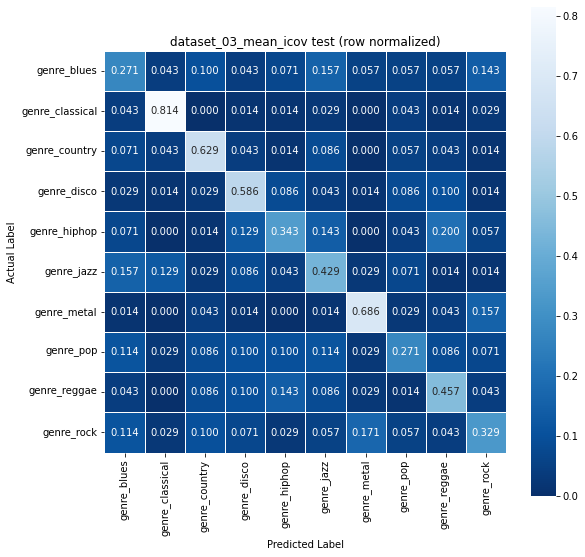



Commencing Experiment: XGBClassifier_dataset_04_mean_cov_icov

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       1.00

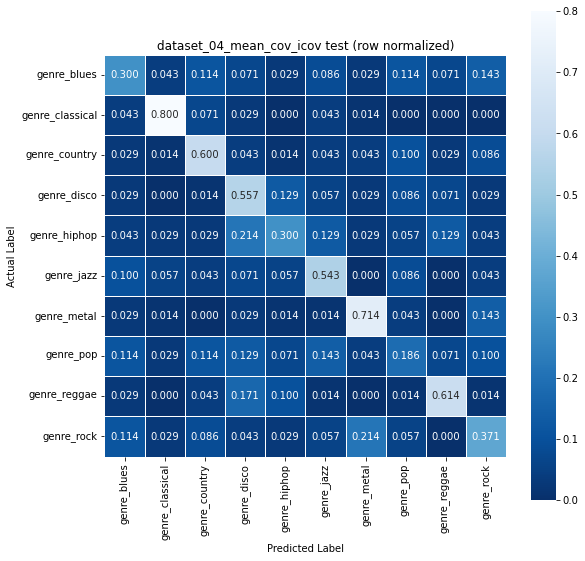



Commencing Experiment: XGBClassifier_dataset_05_pvtt

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       1.0000     28

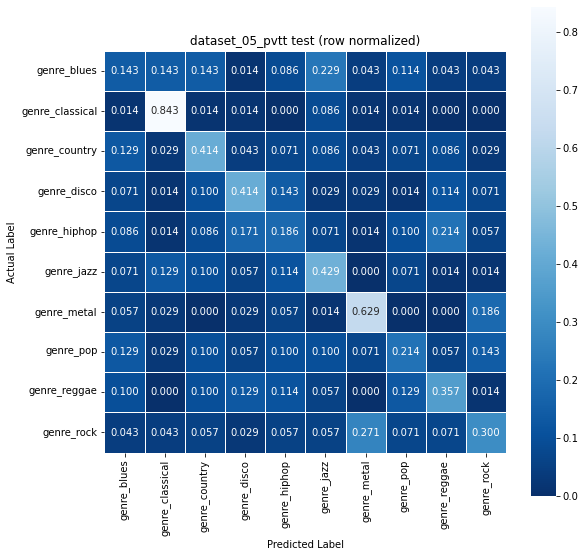



Commencing Experiment: XGBClassifier_dataset_06_pvtt_mean

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       1.0000  

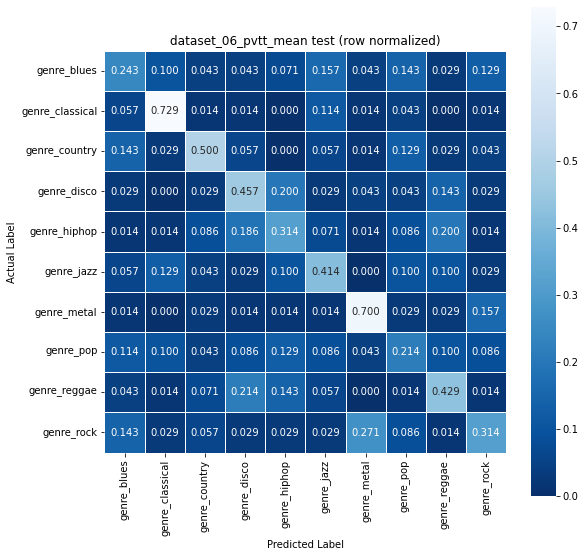



Commencing Experiment: XGBClassifier_dataset_07_pvtt_mean_cov

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       1.00

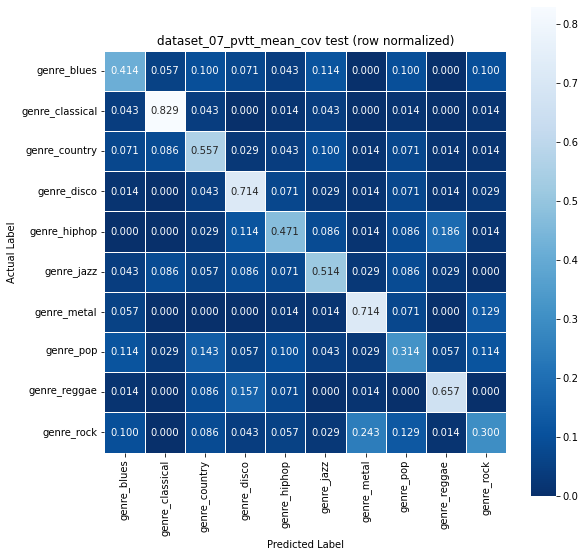



Commencing Experiment: XGBClassifier_dataset_08_pvtt_mean_icov

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       1.0

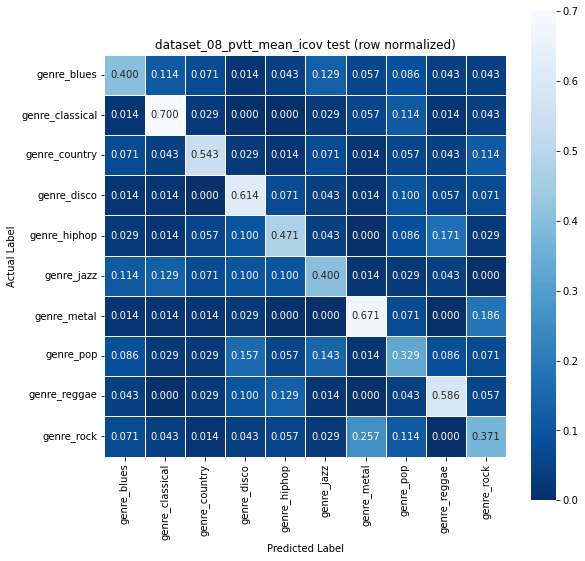



Commencing Experiment: XGBClassifier_dataset_09_pvtt_mean_cov_icov

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                      

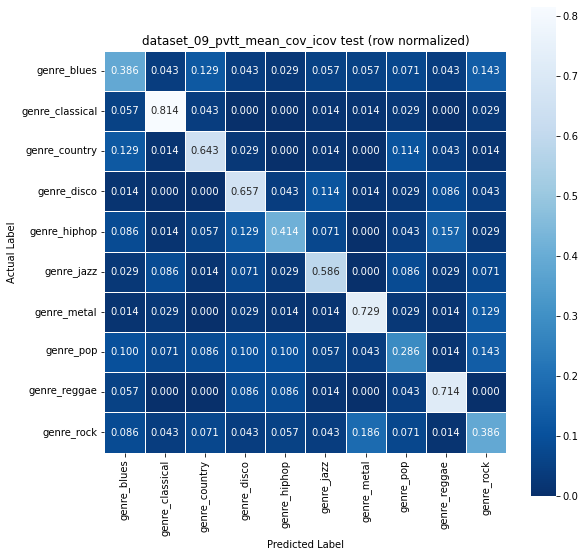



Commencing Experiment: XGBClassifier_dataset_10_melspecs_flat

Training accuracy: train_accuracy = 1.000000

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      280  1.0000
  genre_classical     1.0000  1.0000    1.0000      280  1.0000
    genre_country     1.0000  1.0000    1.0000      280  1.0000
      genre_disco     1.0000  1.0000    1.0000      280  1.0000
     genre_hiphop     1.0000  1.0000    1.0000      280  1.0000
       genre_jazz     1.0000  1.0000    1.0000      280  1.0000
      genre_metal     1.0000  1.0000    1.0000      280  1.0000
        genre_pop     1.0000  1.0000    1.0000      280  1.0000
     genre_reggae     1.0000  1.0000    1.0000      280  1.0000
       genre_rock     1.0000  1.0000    1.0000      280  1.0000
                                                               
         accuracy                       1.00

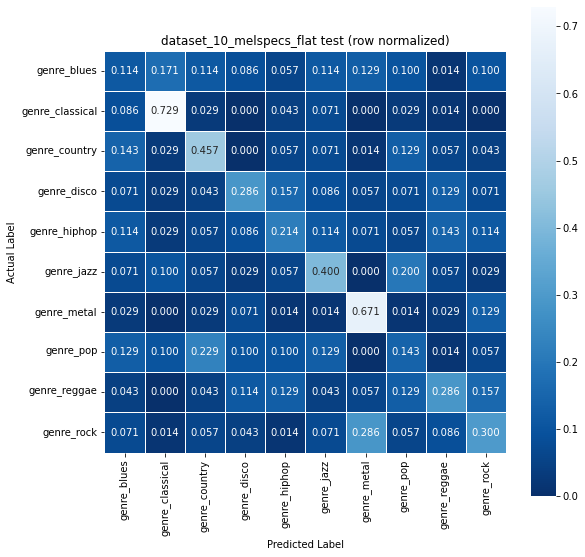

In [2]:
dataset_folder = "../../../datasets/"
datasets = sorted([name for name in glob.glob(dataset_folder + "dataset_*.pickle")])

### For XGBClassifier we need to calculate class weights with sklearn first
### The imbalance in our datasets is the same, so we can pick one of the
### smaller sets (by feature size) to calculate class weights.

df = pd.read_pickle(dataset_folder + "dataset_01_mean.pickle")
_, (y, _), _ = tag_label_feature_split(df, label_format="encoded")
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

for dataset in datasets:
    model = XGBClassifier(
        use_label_encoder=False, objective="multi:softprob", eval_metric="mlogloss",
    )
    experiment(
        model, dataset, samples_per_genre=350, result_filename="rich_results.json"
    )